# Recommendation System using the Abstract

In [10]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def load_data(file_name,head = 50000):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [12]:
DIR = './'
books = load_data(os.path.join(DIR, 'goodreads_books.json.gz'))

In [13]:
print(' sample record (books) ')
display(books[1])

 == sample record (books) ==


{'isbn': '0743509986',
 'text_reviews_count': '6',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '2634', 'name': 'to-read'},
  {'count': '160', 'name': 'fiction'},
  {'count': '92', 'name': 'currently-reading'},
  {'count': '25', 'name': 'contemporary-fiction'},
  {'count': '22', 'name': 'owned'},
  {'count': '19', 'name': 'book-club'},
  {'count': '17', 'name': 'chick-lit'},
  {'count': '16', 'name': 'friendship'},
  {'count': '15', 'name': 'books-i-own'},
  {'count': '12', 'name': 'novel'},
  {'count': '12', 'name': 'general-fiction'},
  {'count': '11', 'name': 'anita-diamant'},
  {'count': '10', 'name': 'owned-books'},
  {'count': '10', 'name': 'contemporary'},
  {'count': '10', 'name': 'women'},
  {'count': '8', 'name': 'adult'},
  {'count': '7', 'name': 'default'},
  {'count': '7', 'name': 'favorites'},
  {'count': '7', 'name': 'didn-t-finish'},
  {'count': '6', 'name': 'own-it'},
  {'count': '6', 'name': 'library'},
  {'count': '6', 'n

In [14]:
for book in books:
    book.pop('popular_shelves')
#     book.pop('similar_books')
    book.pop('authors')
    book.pop('series')
    book.pop('kindle_asin')
    book.pop('title_without_series')
    
    

In [15]:
df = pd.DataFrame(books)
df.head()

,isbn,text_reviews_count,country_code,language_code,asin,is_ebook,average_rating,similar_books,description,format,...,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title
0,0312853122,1,US,,,false,4.00,[],,Paperback,...,9780312853129,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3,5400751,W.C. Fields: A Life on Film
1,0743509986,6,US,,,false,3.23,"[8709549, 17074050, 28937, 158816, 228563, 112...","Anita Diamant's international bestseller ""The ...",Audio CD,...,9780743509985,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10,1323437,Good Harbor
2,,7,US,eng,B00071IKUY,false,4.03,"[19997, 828466, 1569323, 425389, 1176674, 2627...",Omnibus book club edition containing the Ladie...,Hardcover,...,,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,3282,US,eng,,false,3.49,"[6604176, 6054190, 2285777, 82641, 7569453, 70...",Addie Downs and Valerie Adler were eight when ...,Hardcover,...,9780743294294,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184,6243154,Best Friends Forever
4,0850308712,5,US,,,false,3.40,[],,,...,9780850308716,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15,278577,Runic Astrology: Starcraft and Timekeeping in ...


In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df = df.astype(str)

df['cleaned'] = df['description'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)

df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asriva12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,isbn,text_reviews_count,country_code,language_code,asin,is_ebook,average_rating,similar_books,description,format,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,cleaned
0,0312853122,1,US,,,false,4.00,[],,Paperback,...,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3,5400751,W.C. Fields: A Life on Film,
1,0743509986,6,US,,,false,3.23,"['8709549', '17074050', '28937', '158816', '22...","Anita Diamant's international bestseller ""The ...",Audio CD,...,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10,1323437,Good Harbor,anita diamant s international bestseller the r...
2,,7,US,eng,B00071IKUY,false,4.03,"['19997', '828466', '1569323', '425389', '1176...",Omnibus book club edition containing the Ladie...,Hardcover,...,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",omnibus book club edition containing ladies ma...
3,0743294297,3282,US,eng,,false,3.49,"['6604176', '6054190', '2285777', '82641', '75...",Addie Downs and Valerie Adler were eight when ...,Hardcover,...,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184,6243154,Best Friends Forever,addie downs valerie adler eight first met deci...
4,0850308712,5,US,,,false,3.40,[],,,...,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15,278577,Runic Astrology: Starcraft and Timekeeping in ...,
5,1599150603,7,US,,,false,4.13,[],"Relates in vigorous prose the tale of Aeneas, ...",Paperback,...,9,,2006,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,287141,46,278578,The Aeneid for Boys and Girls,relates vigorous prose tale aeneas legendary a...
6,0425040887,4,US,,,false,4.38,[],,Paperback,...,3,,1979,https://www.goodreads.com/book/show/378460.The...,https://s.gr-assets.com/assets/nophoto/book/11...,378460,12,368291,The Wanting of Levine,
7,1934876569,6,US,,,false,4.22,"['948696', '439885', '274955', '12978730', '37...","To Kara's astonishment, she discovers that a p...",Paperback,...,3,,2009,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,6066812,98,701117,All's Fairy in Love and War (Avalon: Web of Ma...,kara s astonishment discovers portal opened be...
8,,4,US,,,true,3.86,[],Secrets. Sometimes keeping them in confidence ...,ebook,...,5,,2017,https://www.goodreads.com/book/show/34883016-p...,https://images.gr-assets.com/books/1493525974m...,34883016,5,56135087,Playmaker: A Venom Series Novella,secrets sometimes keeping confidence good thin...
9,0922915113,39,US,,,false,3.81,"['287151', '1104760', '1172822', '440292', '28...","Wisdom, humor, and dark observations by the fo...",Paperback,...,4,,2000,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,287149,986,278586,The Devil's Notebook,wisdom humor dark observations founder church ...


In [19]:
def recommend(title):
    
    global rec
    data = df
    data.reset_index(level = 0, inplace = True, drop=True) 
  
    try:
        
        # Convert the index into series
        indices = pd.Series(data.index, index = data['title']).drop_duplicates()
    
        #Converting the book description into vectors and used bigram
        tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
        tfidf_matrix = tf.fit_transform(data['cleaned'])

        # Calculating the similarity measures based on Cosine Similarity
        sg = cosine_similarity(tfidf_matrix, tfidf_matrix)

        item = data[['title', 'image_url']]
        # Get the index corresponding to original_title
        idx = indices[title]

        # Get the pairwsie similarity scores 
        sig = list(enumerate(sg[idx]))

        # Sort the books
        sig = sorted(sig, key=lambda x: x[1], reverse=True)

        # Scores of the 5 most similar books 
        sig = sig[1:11]

        # Book indicies
        book_indices = [i[0] for i in sig]

        # Top 5 book recommendation
        rec = item.iloc[book_indices]


        for index, row in rec.iterrows():

            response = requests.get(row['image_url'])
            img = Image.open(BytesIO(response.content))
            plt.figure()
            plt.imshow(img)
            plt.title(row['title'])

    except KeyError:
        print(title, ' Not Found.')
        return
    
    

In [20]:
recommend("Abc")

Abc  Not Found.


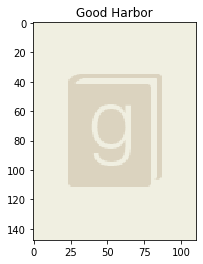

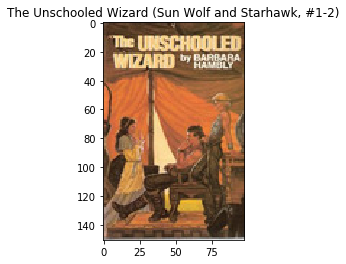

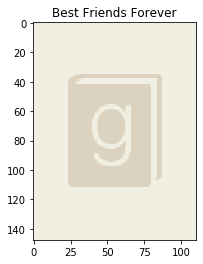

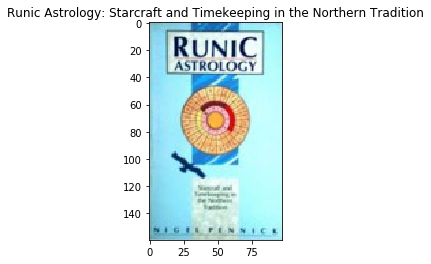

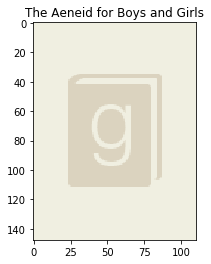

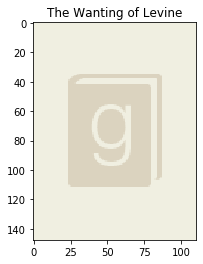

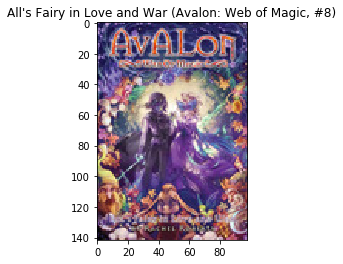

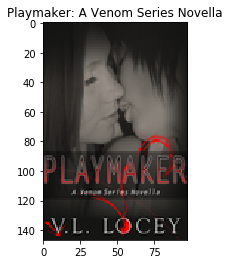

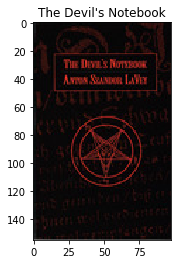

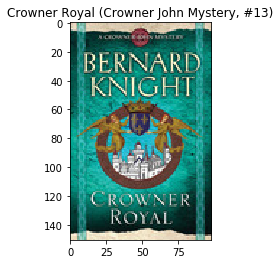

In [21]:
recommend("The Wanting of Levine")

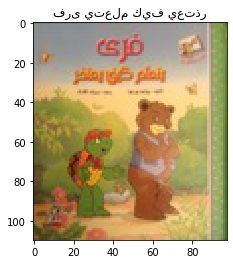

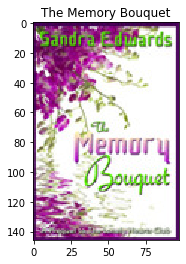

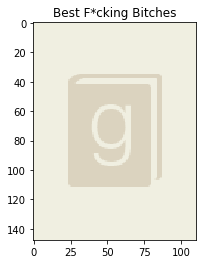

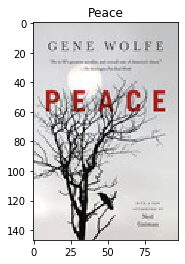

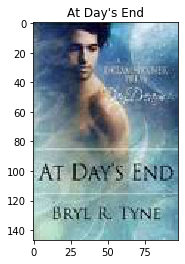

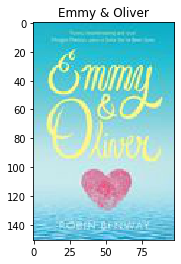

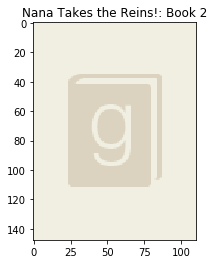

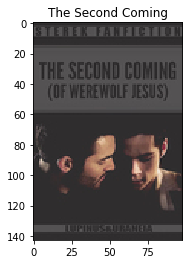

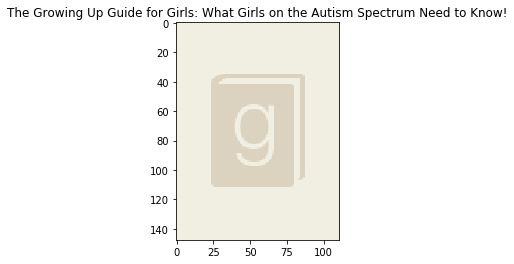

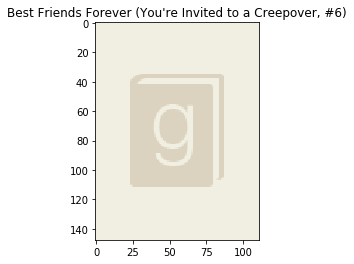

In [22]:
recommend("Best Friends Forever")